# Eli Lilly’s insulin price cuts may provide relief for Americans, but is it enough?

In [23]:
import pandas as pd
from plotnine import *

pd.set_option("display.max_columns", None)

## NHIS data shows the extent of insulin rationing

A survey of Americans that asks about a variety of health conditions, including diabetes, shows that 14% of Americans surveyed taking insulin skipped, reduced, or delayed taking insulin to save money. 24% of insulin users who took the survey and also recieve public assistance or welfare reported rationing. 18% of Black insulin users reported rationing, above the average.

I would need to speak with experts to discern whether the sample size is large enough in these calculations to derive meaningful conclusions. 

In [5]:
df = pd.read_csv('adult21.csv')

In [6]:
# People taking insulin (HHX is a unique identifer for respondant)
insulin_df = df[(df.DIBINS_A == 1)]
total_insulin = insulin_df.HHX.nunique()

# Total number of people that marked one of three categories - delayed taking insulin, skipped doses, or 
# took less insulin to save money
rationing_df = insulin_df[(insulin_df.INSSKIP12M_A == 1) 
                            | (insulin_df.INSLESS12M_A == 1)
                            | (insulin_df.INSDLY12M_A == 1)]
total_rationing = rationing_df.HHX.nunique()

print('total rationing:', total_rationing)
print('total using insulin:', total_insulin)
pct_rationing = total_rationing / total_insulin * 100
pct_rationing

total rationing: 144
total using insulin: 1004


14.342629482071715

In [7]:
# Percentage above among uninsured patients - likely too few people for accurate percentage
uninsured_rationing = rationing_df[(rationing_df.COVER_A == 4) | (rationing_df.COVER65_A == 6)].HHX.nunique()
print('total uninsured using insulin:', uninsured_rationing)
uninsured_rationing / total_rationing * 100

total uninsured using insulin: 9


6.25

In [8]:
# Looking by race, a larger percentage of black respondants (2) ration insulin than white respondants (1)
race_rationing = rationing_df.RACEALLP_A.value_counts().reset_index(name='race_rationing')
race_insulin = insulin_df.RACEALLP_A.value_counts().reset_index(name='race_insulin')
race_breakdown = race_rationing.merge(race_insulin, on='index')
race_breakdown['pct'] = race_breakdown.race_rationing / race_breakdown.race_insulin * 100
race_breakdown

,index,race_rationing,race_insulin,pct
0,1,98,696,14.080460
1,2,35,192,18.229167
2,8,7,54,12.962963
3,6,2,6,33.333333
4,3,1,32,3.125000
5,5,1,12,8.333333


In [9]:
# Looking by whether respondant recieves public income assistance as a proxy for low-income (1),
# low-income diabetes users ration at nearly double the rate
income_rationing = rationing_df.INCWELF_A.value_counts().reset_index(name='income_rationing')
income_insulin = insulin_df.INCWELF_A.value_counts().reset_index(name='income_insulin')
income_breakdown = income_rationing.merge(income_insulin, on='index')
income_breakdown['pct'] = income_breakdown.income_rationing / income_breakdown.income_insulin * 100
income_breakdown

,index,income_rationing,income_insulin,pct
0,2.0,122,895,13.631285
1,1.0,12,50,24.000000
2,9.0,1,2,50.000000
3,8.0,1,3,33.333333


## MEPS data provides insight into the costs' of Eli Lilly's drugs

Using the Medical Expenditure Panel Survey, we can assess how much patients are paying for Humalog and Humalin, the drugs Eli Lilly will be reducing the cost of by 70%. We can also comapre those costs to the costs of insulin products produced by Sanofi and Novo Nordisk, the other two companies dominating the insulin market. 

In [10]:
meps = pd.read_excel('h2020a.xlsx')

In [11]:
total_lilly = meps[(meps.RXNAME.str.contains('HUMALOG') == True) | (meps.RXNAME.str.contains == 'HUMULIN')].shape[0]
total_insulin = meps[meps.RXDRGNAM.str.contains('INSULIN')].shape[0]
total_lilly / total_insulin * 100

12.02391118701964

In [12]:
# Average out-of-pocket cost per scrip among all patients recieving Humalog and Humalin (Eli Lilly drugs)
meps[(meps.RXNAME.str.contains('HUMALOG') == True) | (meps.RXNAME.str.contains('HUMULIN') == True)].RXSF20X.mean()

38.71377840909091

In [13]:
# Average out-of-pocket cost per scrip among all UNINSURED patients recieving Humalog and Humalin (Eli Lilly drugs)
# Setting the out of pocket cost equal to the total cost - that way we can see they recieved no assistance
meps[(meps.RXSF20X == meps.RXXP20X) &
    ((meps.RXNAME.str.contains('HUMALOG') == True) | (meps.RXNAME.str.contains('HUMULIN') == True))].RXSF20X.mean()

225.28947368421052

In [14]:
# Cost of the drugs before insurance 
meps[(meps.RXNAME.str.contains('HUMALOG') == True) | (meps.RXNAME.str.contains('HUMULIN') == True)].RXXP20X.mean()

842.8568892045455

In [15]:
# Once Eli Lilly reduces prices by 70%, the price of the drug before insurance
842 - (842 * 0.7)

252.60000000000002

In [99]:
# Looking at average insulin prices across drug companies
eli_lilly = ['HUMALOG', 'HUMULIN', 'BASAGLAR']
novo = ['FIASP', 'LEVEMIR', 'TOUJEO']
sanofi = ['ADMELOG', 'LANTUS', 'NOVOLIN', 'NOVOLOG', 'TRESIBA']
meps.loc[meps.RXNAME_SIMPLE.isin(eli_lilly), 'COMPANY'] = 'Eli Lilly'
meps.loc[meps.RXNAME_SIMPLE.isin(sanofi), 'COMPANY'] = 'Sanofi'
meps.loc[meps.RXNAME_SIMPLE.isin(novo), 'COMPANY'] = 'Novo Nordisk'

In [136]:
#takes a long time to run
meps19 = pd.read_excel('h2019a.xlsx', usecols = ['RXNAME', 'RXDRGNAM', 'RXSF19X'])
meps18 = pd.read_excel('h2018a.xlsx', usecols = ['RXNAME', 'RXDRGNAM', 'RXSF18X'])
meps17 = pd.read_excel('h2017a.xlsx', usecols = ['RXNAME', 'RXDRGNAM', 'RXSF17X'])

In [182]:
# Year over year
years_dfs = [meps, meps19, meps18, meps17]
years = ['20', '19', '18', '17']
company_means = []
for index, df in enumerate(years_dfs):
    varname = 'RXSF' + years[index] + 'X'
    df['RXNAME_SIMPLE'] = df.RXNAME.str.extract('(\w+)', expand=False)
    df.RXNAME_SIMPLE = df.RXNAME_SIMPLE.str.replace('NOVLIN', 'NOVOLIN') #fixing what appears to be a typo
    df.loc[df.RXNAME_SIMPLE == 'INS', 'RXNAME_SIMPLE'] = 'INSULIN' #standardizing what appears to be abbreviation
    eli_lilly = ['HUMALOG', 'HUMULIN', 'BASAGLAR']
    novo = ['FIASP', 'LEVEMIR', 'TOUJEO']
    sanofi = ['ADMELOG', 'LANTUS', 'NOVOLIN', 'NOVOLOG', 'TRESIBA']
    df.loc[df.RXNAME_SIMPLE.isin(eli_lilly), 'COMPANY'] = 'Eli Lilly'
    df.loc[df.RXNAME_SIMPLE.isin(sanofi), 'COMPANY'] = 'Sanofi'
    df.loc[df.RXNAME_SIMPLE.isin(novo), 'COMPANY'] = 'Novo Nordisk'
    df_company = df[df.RXDRGNAM.str.contains('INSULIN')].groupby('COMPANY')[varname].mean().reset_index()
    df_company['year'] = years[index]
    df_company.rename(columns={varname:'PRICE'},inplace=True)
    company_means.append(df_company)
company_means_df = pd.concat(company_means)

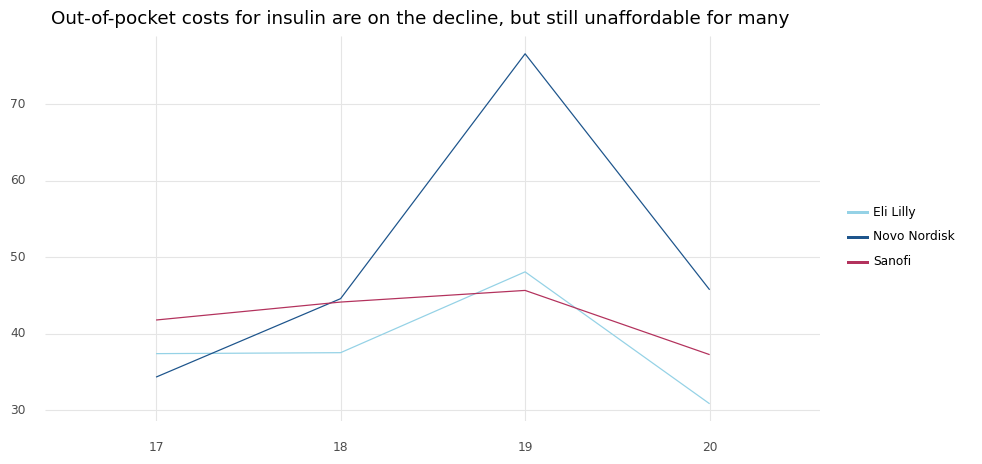

<ggplot: (315946537)>

In [213]:
# Visualizing
colors = {'Eli Lilly':'#95d2e6', 'Sanofi':'#b3325d', 'Novo Nordisk':'#1e558c'}
display(
    ggplot(company_means_df)
    + geom_line(aes(x='year', y='PRICE', group='COMPANY', color='COMPANY'))
    + scale_color_manual(values=colors)
    + theme_minimal()
    + theme(panel_grid_minor=element_blank())
    + labs(title="Out-of-pocket costs for insulin are on the decline, but still unaffordable for many",
           x="",
           y="",
           color="")
    + theme(figure_size=(10,5))
)

In [197]:
meps.groupby('COMPANY').DUID.nunique()

COMPANY
Eli Lilly       275
Novo Nordisk    155
Sanofi          509
Name: DUID, dtype: int64